In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

## The GE dataset

In [2]:
df = pd.read_csv("/opt/app/data/workspace/GEPrediction-OSRS/data/rsbuddy/buy_average.csv")
df = df.set_index('timestamp')

In [3]:
df.head()

Cannonball  Cannon_base  Cannon_stand  Looting_bag_note  \
timestamp                                                             
1628048683           0            0             0                 0   
1628082181           0            0             0                 0   

            Cannon_barrels  Rune_pouch_note  Cannon_furnace  \
timestamp                                                     
1628048683               0                0               0   
1628082181               0                0               0   

            Blighted_manta_ray  Blighted_anglerfish  Blighted_karambwan  ...  \
timestamp                                                                ...   
1628048683                   0                    0                   0  ...   
1628082181                   0                    0                   0  ...   

            Twisted_blueprints  Twisted_horns  \
timestamp                                       
1628048683                   0              0   
1628082181                   0              0   

            Twisted_relic_hunter_(t1)_armour_set  \
timestamp                                          
1628048683                                     0   
1628082181                                     0   

            Twisted_relic_hunter_(t2)_armour_set  \
timestamp                                          
1628048683                                     0   
1628082181                                     0   

            Twisted_relic_hunter_(t3)_armour_set  Inquisitor's_armour_set  \
timestamp                                                                   
1628048683                                     0                        0   
1628082181                                     0                        0   

            Jar_of_dreams  Harmonised_orb  Volatile_orb  Eldritch_orb  
timestamp                                                              
1628048683              0               0             0             0  
1628082181              0               0             0             0  

[2 rows x 3762 columns]

In [ ]:
df.shape

(3398, 3657)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(1086, 3657)

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [ ]:
TRAIN_SPLIT = 750

In [ ]:
tf.random.set_seed(13)

## Part 1: Univariate time series

In [ ]:
uni_data = df['Chaos_rune']
uni_data.head()

timestamp
1577227800    66
1577229600    66
1577231400    66
1577233501    66
1577235300    66
Name: Chaos_rune, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027E173C71D0>],
      dtype=object)

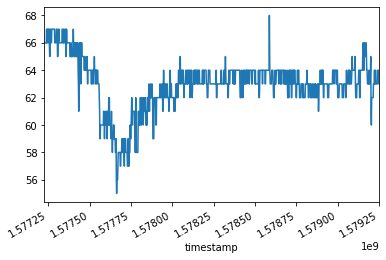

In [ ]:
uni_data.plot(subplots=True)

In [ ]:
uni_data = uni_data.values

In [ ]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [ ]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [ ]:
univariate_past_history = 30
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [ ]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target to predict')
print (y_train_uni[0])

Single window of past history
[[1.37811225]
 [1.37811225]
 [1.37811225]
 [1.37811225]
 [1.37811225]
 [1.37811225]
 [1.37811225]
 [1.81496101]
 [1.37811225]
 [1.37811225]
 [1.81496101]
 [1.81496101]
 [1.37811225]
 [1.81496101]
 [1.81496101]
 [1.81496101]
 [1.37811225]
 [0.94126348]
 [0.94126348]
 [1.81496101]
 [1.81496101]
 [1.37811225]
 [1.37811225]
 [1.37811225]
 [1.81496101]
 [1.81496101]
 [1.81496101]
 [1.81496101]
 [1.81496101]
 [1.81496101]]

 Target to predict
1.8149610136382854


In [3]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [4]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [5]:
plot = show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')
plot.show()

NameError: name 'x_train_uni' is not defined

### Baseline


In [ ]:
def baseline(history):
  return np.mean(history)

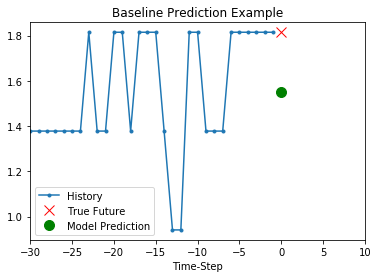

In [ ]:
plot = show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')
plot.show()

### Recurrent neural network

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 30

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [ ]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(32, 1)


In [6]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

NameError: name 'simple_lstm_model' is not defined

#### Predict using the simple LSTM model


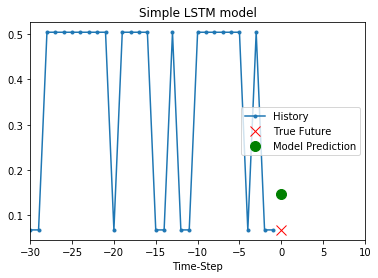

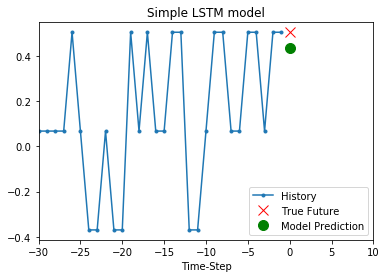

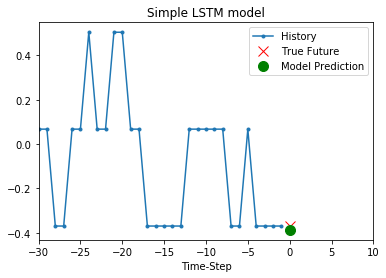

In [ ]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

## Part 2: Multivariate time series

In [ ]:
features_considered = ['Nature_rune', 'Soul_rune', 'Blood_rune', 'Law_rune']

In [ ]:
features = df[features_considered]
# features.index = df['timestamp']
features.head()

Nature_rune  Soul_rune  Blood_rune  Law_rune
timestamp                                               
1577227800          218        146         305       142
1577229600          219        147         304       142
1577231400          218        146         304       142
1577233501          218        145         304       140
1577235300          218        144         301       140

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027E32A579B0>,
      dtype=object)

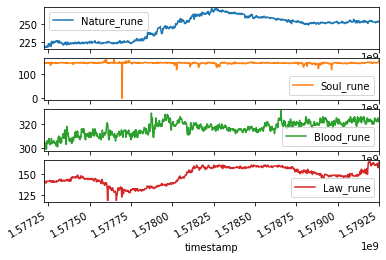

In [ ]:
features.plot(subplots=True)

In [ ]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [ ]:
dataset = (dataset-data_mean)/data_std

### Single step model

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
past_history = 30
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (30, 4)


In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [ ]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(32, 1)


In [ ]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 7s 34ms/step - loss: 0.3055 - val_loss: 0.3105
Epoch 2/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2746 - val_loss: 0.3035
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2655 - val_loss: 0.3052
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2660 - val_loss: 0.3126
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2556 - val_loss: 0.3125
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2517 - val_loss: 0.3261
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2541 - val_loss: 0.3246
Epoch 8/10
200/200 [==============================] - 4s 21ms/step - loss: 0.2460 - val_loss: 0.3223
Epoch 9/10
200/200 [==============================] - 4s 21ms/step - loss: 0.2422 - val_loss: 0.3285
Epoch 10/10
200/200 [===========================

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

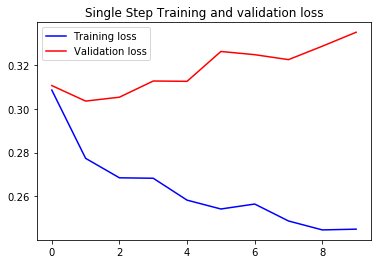

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future

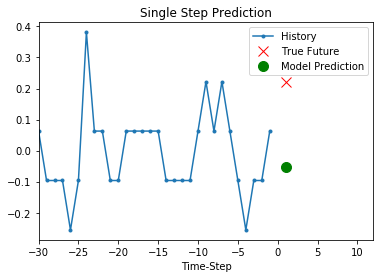

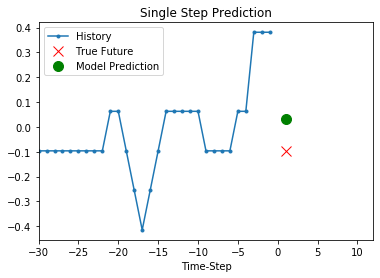

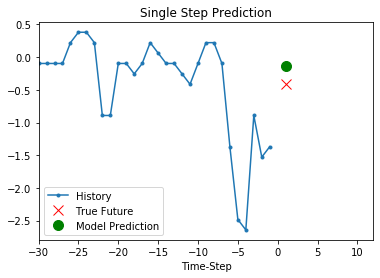

In [ ]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Single Step Prediction')
  plot.show()

### Multi-Step model

In [ ]:
future_target = 5
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [ ]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (30, 4)

 Target temperature to predict : (5,)


In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

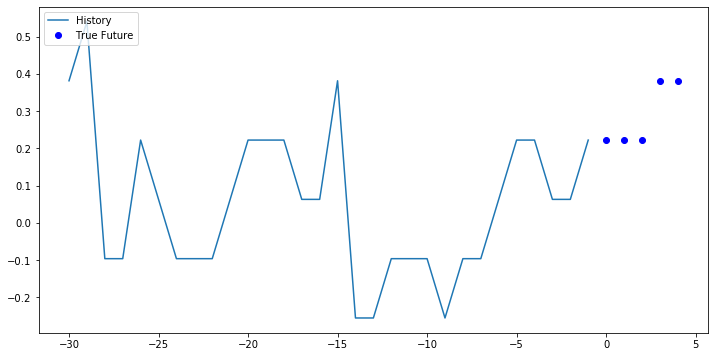

In [ ]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
# multi_step_model.add(tf.keras.layers.Dense(72))
multi_step_model.add(tf.keras.layers.Dense(future_target))


multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(32, 5)


In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 15s 76ms/step - loss: 0.3093 - val_loss: 0.3456
Epoch 2/10
200/200 [==============================] - 8s 39ms/step - loss: 0.2932 - val_loss: 0.3352
Epoch 3/10
200/200 [==============================] - 8s 39ms/step - loss: 0.2788 - val_loss: 0.3365
Epoch 4/10
200/200 [==============================] - 7s 34ms/step - loss: 0.2754 - val_loss: 0.3300
Epoch 5/10
200/200 [==============================] - 7s 35ms/step - loss: 0.2645 - val_loss: 0.3380
Epoch 6/10
200/200 [==============================] - 8s 39ms/step - loss: 0.2582 - val_loss: 0.3397
Epoch 7/10
200/200 [==============================] - 7s 34ms/step - loss: 0.2578 - val_loss: 0.3597
Epoch 8/10
200/200 [==============================] - 7s 35ms/step - loss: 0.2454 - val_loss: 0.3616
Epoch 9/10
200/200 [==============================] - 7s 35ms/step - loss: 0.2390 - val_loss: 0.3636
Epoch 10/10
200/200 [==========================

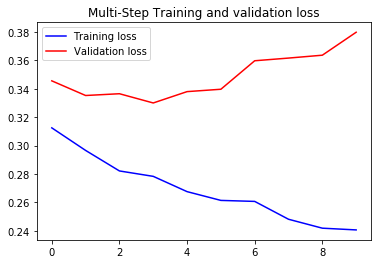

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future

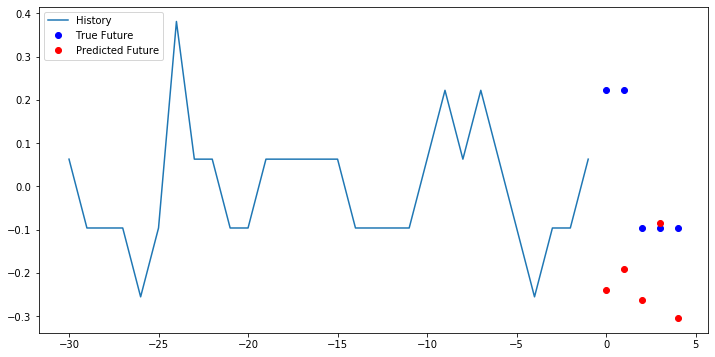

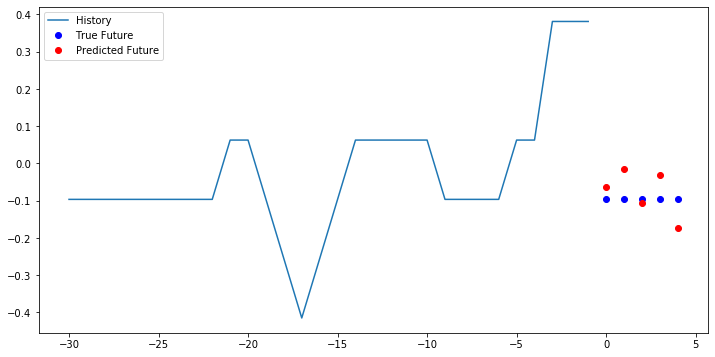

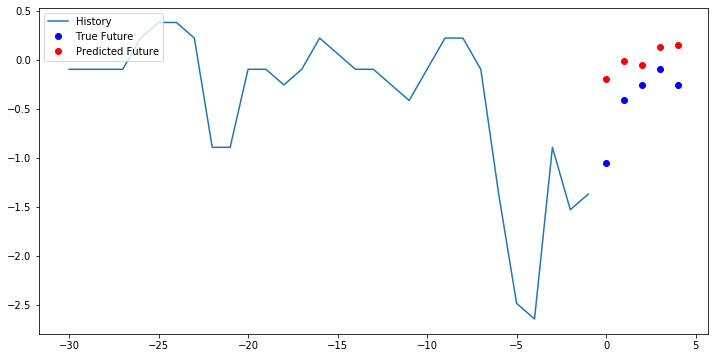

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])